# Week 3. Day 1. Exercises from Chapter 7 of FSStDS. 
## Fundamentals of Social Data Science. MT 2022

Within your NEW study pod discuss the following questions. Please submit an individual assignment by 12:30pm Tuesday, October 25, 2022 on Canvas. 

# Exercise 1. How busy is twitter now? 

Using the `counts` endpoint, compare the chatter around three British politicians, Penny Mordunt, Rishi Sunak, and Boris Johnson. Use the name of the politicians in separate queries:
1. Which politician had the most mentions overall?
2. For each politician, what was the hour of pean mentions? Was it the same for each person? 

In [7]:
import pandas as pd
import numpy as np
import requests as req
import json
import datetime as dt
import dateutil
import math 
import matplotlib.pyplot as plt
import re
import praw
from psaw import PushshiftAPI
import dotenv
config = dotenv.dotenv_values("../.env")

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.downloader import download
download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/matthewbone/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# Answer 1 below here
url = 'https://api.twitter.com/2/tweets/counts/recent'

BEARER = config['TWITTER_BEARER_TOKEN']
headers = {"Authorization": f"Bearer {BEARER}"}

poli_df = pd.DataFrame()
for poli in ['Penny Mordaunt', 'Rishi Sunak', 'Boris Johnson', 'Liz Truss', 'Lettuce']:

    params = {
        'query': poli,
        'granularity': 'hour',
        'start_time': '2022-10-24T00:00:00.000Z'
    }

    res = json.loads(req.get(url, headers=headers, params=params).content)
    temp_df = pd.DataFrame(res['data'])
    temp_df['politician'] = poli
    temp_df['total'] = res['meta']['total_tweet_count']
    poli_df = pd.concat([poli_df, temp_df])
    
mentions_df = poli_df.sort_values('tweet_count').groupby('politician').tail(1)
display(mentions_df)
print(f"{mentions_df.sort_values('total').tail(1).iloc[0,3]} has the most mentions with {mentions_df.sort_values('total').tail(1).iloc[0,4]}", end = '\n\n')

for i in range(len(mentions_df)):
    print(f"{mentions_df.iloc[i, 3]}'s peak tweet mention hour was at {mentions_df.iloc[i, 1][11:-8]}")

print('The peak hours were the same for everyone except for Boris Johnson')

# Answer 1 above here


,end,start,tweet_count,politician,total
13,2022-10-24T14:00:00.000Z,2022-10-24T13:00:00.000Z,1052,Lettuce,14697
13,2022-10-24T14:00:00.000Z,2022-10-24T13:00:00.000Z,8262,Liz Truss,75093
7,2022-10-24T08:00:00.000Z,2022-10-24T07:00:00.000Z,9906,Boris Johnson,145214
13,2022-10-24T14:00:00.000Z,2022-10-24T13:00:00.000Z,13941,Penny Mordaunt,43672
13,2022-10-24T14:00:00.000Z,2022-10-24T13:00:00.000Z,91424,Rishi Sunak,687219


Rishi Sunak has the most mentions with 687219

Lettuce's peak tweet mention hour was at 13:00
Liz Truss's peak tweet mention hour was at 13:00
Boris Johnson's peak tweet mention hour was at 07:00
Penny Mordaunt's peak tweet mention hour was at 13:00
Rishi Sunak's peak tweet mention hour was at 13:00
The peak hours were the same for everyone except for Boris Johnson


# Exercise 2. Tweets across the world

Select a query to download 100 tweets. Include the locations entities. Can you find a query where no single country makes up more than 50% of the locations? How can you automate this using a bank of queries? 

**I currently have elevated access rather than academic access, and it seems that [I can't use the "has:geo" flag](https://stackoverflow.com/questions/74125493/issues-with-twitter-api-v2-elevated-access-and-hasgeo-query-parameter) because of this. This means the tweets I pull often don't have countries connected to them. However, over 2021, I collected ~700,000 tweets about the vaccine via the twitter API (can download [here](https://drive.google.com/file/d/1uyGa9S5nrV7yBwFGJSOT_0hBzy--5wbE/view?usp=sharing)) that I haven't every analyzed so I hope you won't mind that I use this a chance to analyze this data instead.**

There are 707313 tweets in this dataset


,created_at,id_str,text,user,country,place,retweet_count,favorite_count,accessed,sentiment
0,2020-12-05 20:45:07,1335324346005524483,"Landlord: Rent is due. \n\nCongress: ""It's oka...",RashidaTlaib,NaN,NaN,3569,22153,NaN,-0.2732
1,2020-12-06 01:00:15,1335388550683009027,A family of Muslim immigrants from Turkey newl...,AndreiCherny,NaN,NaN,8244,30397,NaN,0.0000
2,2020-12-06 16:44:32,1335626187020840961,The surge in COVID cases in our region is dang...,RepAdamSchiff,NaN,NaN,2344,13213,NaN,-0.4404
3,2020-12-05 15:34:13,1335246104015859715,Some positive news - initial supplies of the C...,NicolaSturgeon,NaN,NaN,2739,35532,NaN,0.7783
4,2020-12-06 18:27:04,1335651989317947396,“Will I take the vaccine?” https://t.co/vg6Ptd...,RexChapman,NaN,NaN,3001,17399,NaN,0.0000


Text(0, 0.5, 'sentiment')

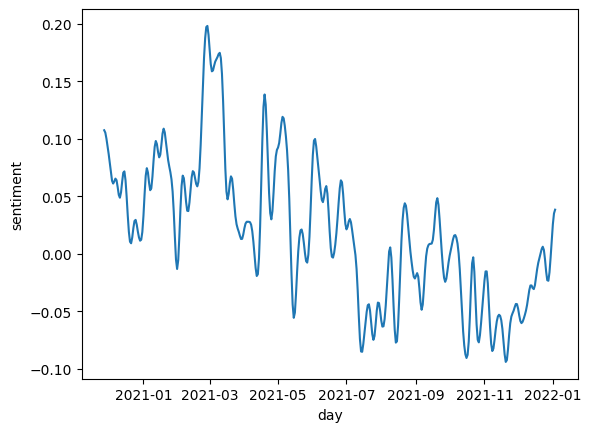

In [21]:
# this block requires the full tweets.csv file, the one below only requires the smaller country_tweets.csv

def smooth_timeseries(df, n):

    smoothed = df[('sentiment', 'mean')].copy()

    for i in range(n):

        new_smoothed = smoothed.copy()

        for j in range(len(smoothed)):

            if not j in [0, len(smoothed) - 1]:
                new_smoothed[j] = smoothed[j] / 2 + (
                    smoothed[j - 1] + smoothed[j + 1]) / 4
            elif j == 0:
                new_smoothed[j] = (
                    smoothed[j] + smoothed[j + 1]) / 2
            else:
                new_smoothed[j] = (
                    smoothed[j] + smoothed[j - 1]) / 2

        smoothed = new_smoothed.copy()

    return smoothed

sia = SentimentIntensityAnalyzer()

tweets_df = pd.read_csv('../data/tweets.csv')
tweets_df['sentiment'] = tweets_df['text'].map(lambda x: sia.polarity_scores(re.sub('[^a-zA-Z ]', '', x).lower())['compound'] if isinstance(x, str) else None)
tweets_df.to_csv('sentiment_tweets.csv')
print(f"There are {len(tweets_df)} tweets in this dataset")
display(tweets_df.head(5))

tweets_df['created_day'] = tweets_df['created_at'].map(
    lambda x: dt.datetime.fromisoformat(x).date())
daily_tweet_df = tweets_df[['created_day', 'sentiment']].groupby(
    'created_day').agg({'sentiment': ['min', 'max', 'mean']})

smoothed_tweets = smooth_timeseries(daily_tweet_df, 10)

plt.plot(daily_tweet_df.index, smoothed_tweets)
plt.xlabel('day')
plt.ylabel('sentiment')


There are 416774 news articles in this dataset


,id,title,link,published,sentiment
0,CBMidWh0dHBzOi8vbmV3cy5hYnBsaXZlLmNvbS92aWRlb3...,Hope PM talks about giving free Corona vaccine...,https://news.abplive.com/videos/news/india-hop...,Fri 04 Dec 2020 06:08:10 GMT,0.8225
1,CBMiJWh0dHBzOi8vZXVvYnNlcnZlci5jb20vc2NpZW5jZS...,Corona-hackers targeted EU officials with bogu...,https://euobserver.com/science/150282,Fri 04 Dec 2020 06:18:00 GMT,0.0000
2,CAIiEHYDyk0K0goSiSuBucMDtyMqGQgEKhAIACoHCAowsL...,Coronavirus LIVE updates: India cases at 95715...,https://www.business-standard.com/article/curr...,Fri 04 Dec 2020 06:02:20 GMT,-0.5994
3,CAIiEBXujzkJHYR6ARF26PIJj64qGQgEKhAIACoHCAowot...,Loss of education cannot be compensated with C...,https://www.indiatoday.in/education-today/news...,Fri 04 Dec 2020 05:48:26 GMT,-0.3182
4,CBMiZGh0dHBzOi8vdGhlc2F4b24ub3JnL2Nvcm9uYXZpcn...,Coronavirus live ticker: The situation on Frid...,https://thesaxon.org/coronavirus-live-ticker-t...,Fri 04 Dec 2020 05:57:00 GMT,0.0000


Text(0, 0.5, 'sentiment')

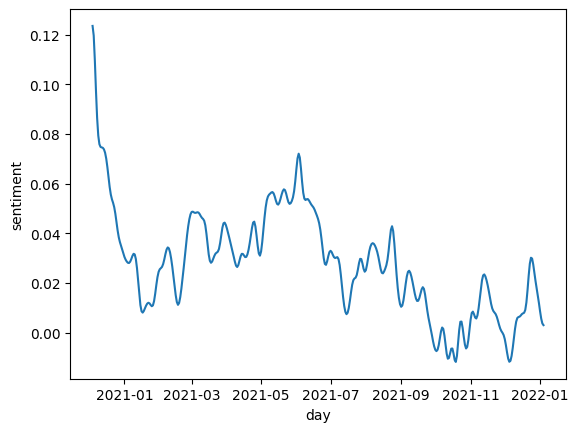

In [22]:
news_df = pd.read_csv('../data/hourly.csv')
news_df = news_df[['id', 'title', 'link', 'published']].drop_duplicates()
news_df['sentiment'] = news_df['title'].map(lambda x: sia.polarity_scores(re.sub('[^a-zA-Z ]', '', x).lower())['compound'] if isinstance(x, str) else None)
news_df.to_csv('sentiment_news.csv')
print(f"There are {len(news_df)} news articles in this dataset")
display(news_df.head(5))

news_df['published_day'] = news_df['published'].map(
    lambda x: dateutil.parser.parse(x).date())
daily_news_df = news_df[['published_day', 'sentiment']].groupby(
    'published_day').agg({'sentiment': ['min', 'max', 'mean']})

smoothed_news = smooth_timeseries(daily_news_df, 10)

plt.plot(daily_news_df.index, smoothed_news)
plt.xlabel('day')
plt.ylabel('sentiment')

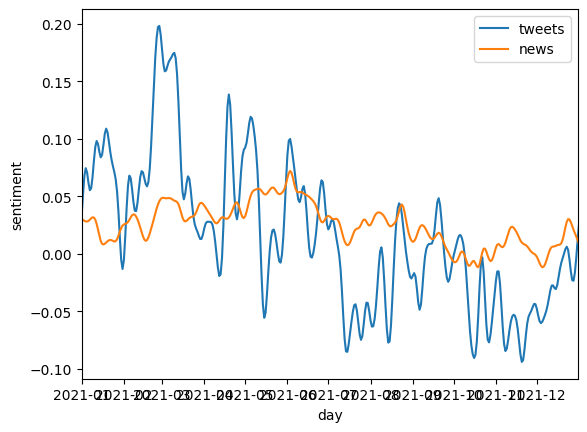

In [26]:
plt.plot(daily_tweet_df.index, smoothed_tweets, label='tweets')
plt.plot(daily_news_df.index, smoothed_news, label='news')
plt.xlim((dt.datetime(2021,1,1), dt.datetime(2021,12,31)))
plt.xlabel('time')
plt.ylabel('sentiment')
plt.legend()

In [86]:
# Answer 2 below here

# tweets_df = pd.read_csv('../data/tweets.csv')
# country_tweets_df = tweets_df[tweets_df['country'].map(lambda x: isinstance(x, str))]
# country_tweets_df.to_csv('country_tweets.csv')

original_number_of_tweets = 707313

country_tweets_df = pd.read_csv('country_tweets.csv')

print(f"Only {(len(country_tweets_df) / original_number_of_tweets):.2%} or {len(country_tweets_df)} of {original_number_of_tweets} tweets have countries attached")
print('Most Common Countries of Those Tweets')
country_counts = country_tweets_df.value_counts('country')
country_percs = country_counts.map(lambda x: round(x / len(country_tweets_df) * 100, 2))
count_df = pd.DataFrame({'count': country_counts, 'perc': country_percs})
display(count_df.head(5))

# Answer 2 above here

Only 0.97% or 6829 of 707313 tweets have countries attached
Most Common Countries of Those Tweets


,count,perc
country,,
United States,3930,57.55
United Kingdom,851,12.46
Canada,549,8.04
Australia,463,6.78
India,323,4.73


# Exercise 3. Comparing `praw` and `psaw`

Reddit mods have considerable power over their subreddits. In /r/Science they are notoriously aggressive in their deletion of non-scientific comments. 

PushShift is an archive of reddit data. You can access this archive using `psaw` which is otherwise very similar to `praw`. Go to /r/science and select a story that over two days old. Compare the comments that you receive from `praw` and `psaw`. Do they have similar: 
- counts of comments?
- counts of comments marked deleted?
- upvote scores on the comments? 

Posit what might account for the difference. Reflect on how this could intervene in making claims about activity on Reddit.

In [82]:
# PRAW

def get_comments(post):
    comment_list = []
    for comment in post.comments:
        temp = {}
        try:
            if comment.body == '[removed]': temp['deleted'] = True 
            else: temp['deleted'] = False
            temp['text'] = comment.body
            temp['upvotes'] = comment.score
        except AttributeError as e:
            continue
        comment_list.append(temp)

    return pd.DataFrame(comment_list)

reddit = praw.Reddit(
    client_id=config['REDDIT_CLIENT_ID'],
    client_secret=config['REDDIT_CLIENT_SECRET'],
    user_agent=config['REDDIT_USER_AGENT']
)

sci = reddit.subreddit('Science')
praw_post = list(sci.hot(limit=5))[-1]

print(f"Original Post Title: \n{praw_post.title}")

praw_df = get_comments(praw_post)

print(f"praw gave us {len(praw_df)} total comments, and {len(praw_df[praw_df['deleted']])} deleted comments")

# PRAW

Original Post Title: 
Record-breaking chip can transmit entire internet's traffic per second. A new photonic chip design has achieved a world record data transmission speed of 1.84 petabits per second, almost twice the global internet traffic per second.
praw gave us 40 total comments, and 7 deleted comments


In [84]:
#PSAW

api = PushshiftAPI()

psaw_post = None
for post in api.search_submissions(subreddit='science', limit=100):
    if post.title == praw_post.title:
        psaw_post = post

print(f"Original Post Title: \n{psaw_post.title}")
print(f"psaw gave us {psaw_post.num_comments} total comments, but doesn't provide any information on deleted comments")

#PSAW

Original Post Title: 
Record-breaking chip can transmit entire internet's traffic per second. A new photonic chip design has achieved a world record data transmission speed of 1.84 petabits per second, almost twice the global internet traffic per second.
psaw gave us 1 total comments, but doesn't provide any information on deleted comments


/Users/matthewbone/Documents/Coding/VSCode/FSDS22/fsd22env/lib/python3.9/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


## Exercise 3 reflections below here 

It seems like PSAW is severely limited in what it is able to get from posts on reddit. There is a significant amount of metadata about the post but it seems inaccurate and you can't actually pull comments from posts. I'm not sure if this PSAW's limitations or my own misuse.

## Exercise 3 reflections above here

# Exercise 4 - Comparing comments 
(in case PushShift isn't working for you)

People can submit the same link to multiple subreddits. You can find out where else a link was submitted on Reddit by xx. 

Select a story that has been submitted to at least two subreddits. Compare the comments for each of these:
- Which subreddit has more comments? Would this have been unexpected? Why?
- Are there any overlap in the users who comment on these stories across the multiple subreddits?
- Summarise the scores of the comments versus the story (`data.ups`). Is the ratio of the top comment score to the ups the same? 
- Which story has more comments that have a score below zero? As a percentage? 


In [8]:
# Exercise 4 below here



# Exercise 4 above here